In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np
import keras
from sklearn.svm import OneClassSVM
from shapely.geometry import Polygon

import rasterio
from rasterio import plot as rastPlt
from rasterio.mask import mask as rasterMask
from rasterio.plot import reshape_as_raster

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)

lightMask = dataRadiance>0
lightCoords = dataCoords[lightMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])


Tiles: 139113
Light Tile: 689


#### Fetch images

In [3]:
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, lightCoords, res=64)
print(trainData.shape)

(689, 64, 64, 3)


#### Prepare Validation

In [4]:
with rasterio.open(pathValidation) as f:
  testTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True)
print('Validation shape:',testTile.shape) # shape sample

print('Process validation...')
getValid = lambda data : [ 0.9 < img.max() for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=testTile.shape[1])

Validation shape: (4, 9, 9)
Process validation...


## Autoencoder + SVM

In [5]:
autoencoder = keras.models.load_model('model/autoencoder_64px_encoder_1024')
encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('encoder').output)

trainDataFormated = encoder.predict(trainData)
validation = dataRadiance[lightMask]

22/22 [==============================] - 0s 6ms/step


In [6]:
svm = OneClassSVM(gamma='scale', kernel='rbf', nu=0.1, tol=1e-3)
svm = svm.fit(trainDataFormated, sample_weight=dataRadiance[lightMask])

# Analyse model

In [10]:
print('Process score...')
getScore = lambda data : [i == 1 for i in svm.predict(encoder.predict(data, verbose=0))]
result = utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=100, res=64)

Process score...


# Confusion Matrix

In [11]:
utils.processConfusionMatrix(result, resultValid, lightMask)

Total light data: 689 Detected: 616 Missed: 73
Population with light detected: 89.4 %

Process confustion matrix...
total data: 139113
[[56909 59170]
 [10120 12914]]
f-score: 27.15 %


# Display the analysed results

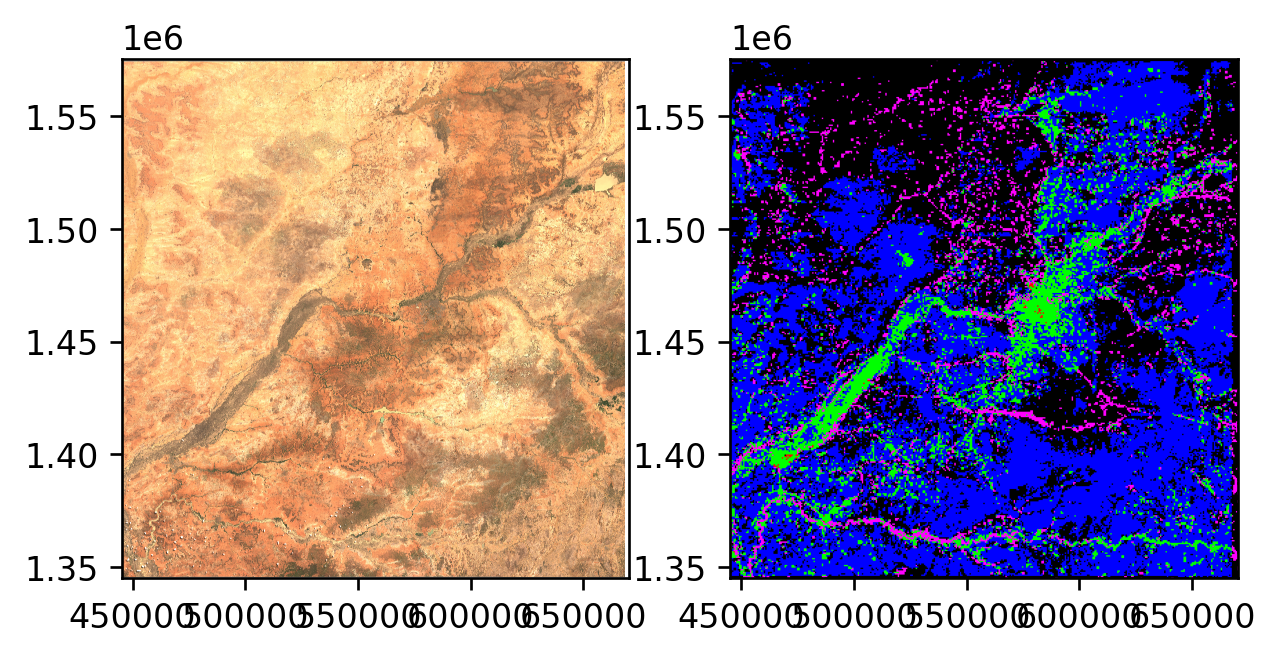

In [12]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, result, resultValid, lightMask)

fig, axs = matPlt.subplots(1,2, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])


In [13]:
img, profile = utils.rasterToImg(resultImg, pathNight)
with rasterio.open(folderName + 'autoencoder_svm_mu_01_Nigeria.tif', 'w', **profile) as f:
  f.write(img)
